In [1]:
import Pkg

Pkg.activate(@__DIR__)

  Activating project at `~/gits/DisjunctiveToQUBO.jl/notebooks`


In [2]:
using Revise
using JuMP
using ToQUBO                 #px/indicator
using DisjunctiveProgramming #master
using DisjunctiveToQUBO
using QUBOTools
using LinearAlgebra
using HiGHS
using DWave

In [3]:
includet("reactors.jl")

In [4]:
# Set parameters
cx = [1.5, 1]
cy = [6.1, 5.9]
α  = [0.75, 0.8]
d  = 3 # not specified in the problem, I think it is 3

3

$$
\begin{array}{rll}
    \displaystyle \min_{\mathbf{x}, \mathbf{Y}} & \mathbf{c_{x}}'\mathbf{x} + \mathbf{c_{y}}'\mathbf{y} \\
    \textrm{s.t.} & \mathbf{\alpha}'\mathbf{x} \ge d \\[0.75em]
                  & \displaystyle%
                    \bigvee_{i = 1}^{2} \left[\begin{array}{c} Y_{i} \\ x_{i} \leq 0 \end{array}\right] \\[1.75em]
                  & 0 \leq x_{i} \leq 5 & \forall i \\
                  & Y_{i} \iff y_{i} = 1 & \forall i \\
                  & Y_{i} \in \{\textrm{True}, \textrm{False}\} & \forall i \\
                  & y_{i} \in \{0, 1\} & \forall i \\[1em]
   \textrm{data}  & \mathbf{c_{x}} = [1.5, 1] \\
                  & \mathbf{c_{y}} = [6.1, 5.9] \\
                  & \mathbf{\alpha} = [0.75, 8] \\
                  & d = 3
\end{array}
$$

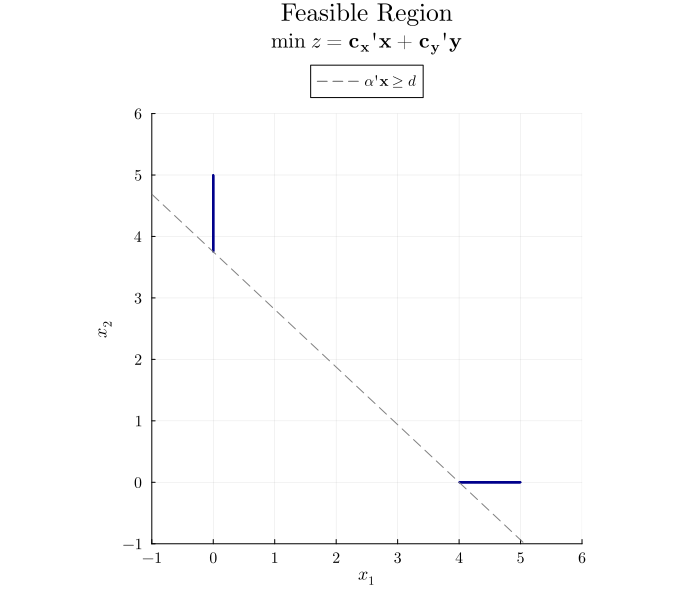

In [5]:
plot_reactor_feasible()

## Optimal Solution

In [6]:
x⃰, z⃰ = let model = solve_gdp_reactors(HiGHS.Optimizer; method=BigM(3.75, false)) do m
        set_silent(m)
    end
    
    value.(model[:x]), objective_value(model)
end

([0.0, 3.75], 9.85)

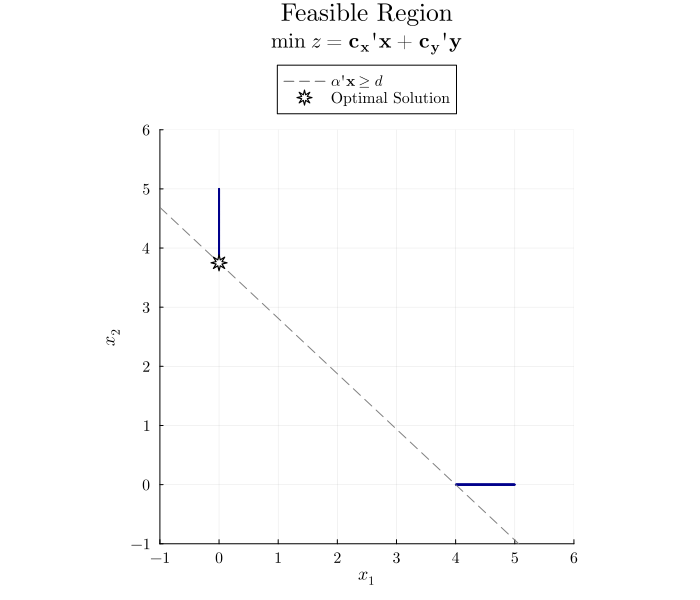

In [25]:
plot_reactor_optimal(x⃰)

## Big-$M$ Reformulation

In [8]:
M = 5.0

bigm_model = solve_gdp_reactors(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = BigM(M, false)
) do m
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(bigm_model)
solution_summary(bigm_model)
sampling_summary(bigm_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 23
  Encoding ………………… 10
  Slack ………………………… 13
  Quadratization … 0

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.5928853754940712

⋄ Coefficient Range
  Lower Bound ………… -32817.25
  Upper Bound ………… 104448.0

⋄ Constant Offset: 59593.5

⋄ Work counters
  Compiltaion Time (sec) : 3.863143267



⋄ Sampling Summary

⋄ Number of samples: 810

⋄ Best energy: 9.849999999998545

⋄ Time-to-target (sec): 1880.4612681508627



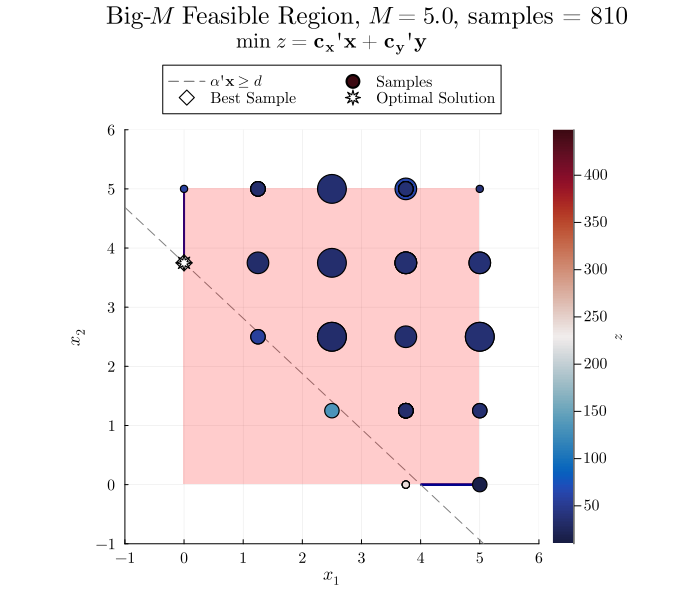

In [26]:
plot_reactor_bigm(bigm_model, x⃰, M)

## Hull Reformulation

In [15]:
hull_model = solve_gdp_reactors(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = Hull()
) do m
    set_attribute(m, "num_reads", 10_000)
    set_attribute(m, "num_sweeps", 2_000)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(hull_model)
solution_summary(hull_model)
sampling_summary(hull_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 53
  Encoding ………………… 22
  Slack ………………………… 31
  Quadratization … 0

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.22060957910014514

⋄ Coefficient Range
  Lower Bound ………… -31389.25
  Upper Bound ………… 104448.0

⋄ Constant Offset: 58777.5

⋄ Work counters
  Compiltaion Time (sec) : 0.000468766

⋄ Sampling Summary

⋄ Number of samples: 8143

⋄ Best energy: 11.10000000000582

⋄ Time-to-target (sec): -Inf



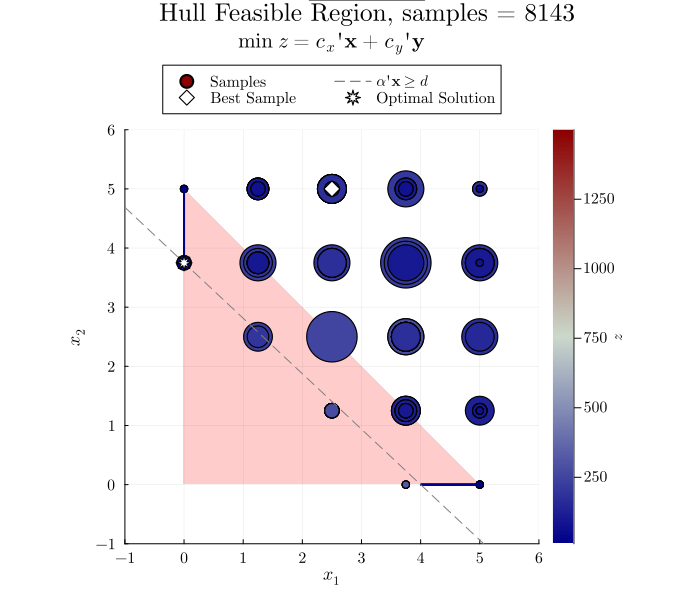

In [32]:
plot_reactor_hull(hull_model, x⃰)

## Indicator Refoormulation

In [21]:
ind_model = solve_gdp_reactors(
    () -> ToQUBO.Optimizer(DWave.Neal.Optimizer),
    method = Indicator()
) do m
    set_attribute(m, "num_reads", 2_000)
    set_attribute(m, "num_sweeps", 2_000)

    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingBits(), 4)
    set_attribute.(m[:x], ToQUBO.Attributes.VariableEncodingMethod(), ToQUBO.Encoding.Unary())
end

compilation_summary(ind_model)
solution_summary(ind_model)
sampling_summary(ind_model, z⃰)

⋄ Compilation Summary

⋄ Solver: D-Wave Neal Simulated Annealing Sampler

⋄ Number of variables: 29
  Encoding ………………… 10
  Slack ………………………… 7
  Quadratization … 12

⋄ Density
  Linear ……………………… 1.0
  Quadratic ……………… 0.3694581280788177

⋄ Coefficient Range
  Lower Bound ………… -32638.75
  Upper Bound ………… 104448.0

⋄ Constant Offset: 58777.5

⋄ Work counters
  Compiltaion Time (sec) : 0.000520566

⋄ Sampling Summary

⋄ Number of samples: 1666

⋄ Best energy: 9.849999999998545

⋄ Time-to-target (sec): 1672.9770401948526



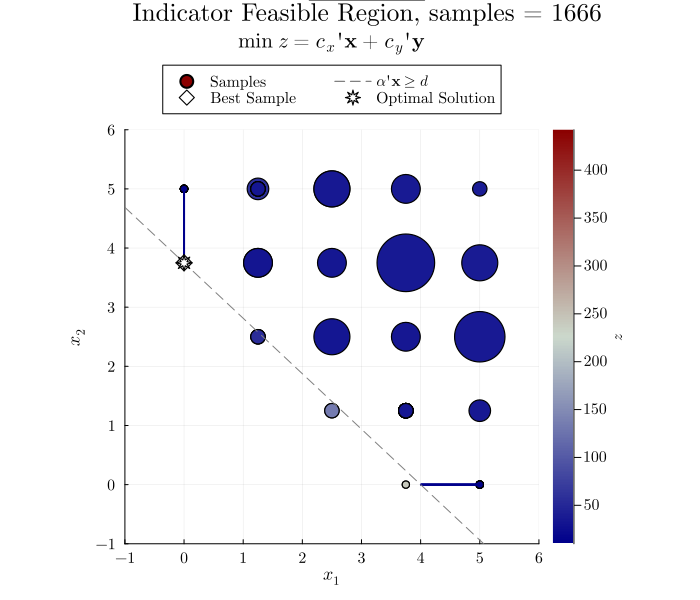

In [28]:
plot_reactor_indicator(ind_model, x⃰)